# Hands on with PyMC
Let's practice everything we have learned this morning. We will be using the `PyMC` library to do Bayesian 
inference and explore posterior distributions. 

We only workout the case of two variants A and B with Bernoulli conversions. For now, we don't use real data yet and simply assume synthetic trials and successes.

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import numpy as np
import pymc as pm

In [2]:
# Set random seed
rng = np.random.default_rng(1)
# Set plotting style
plotting_defaults = dict(bins=50,kind="hist",textsize=8,)

## Your First Try

In [3]:
# let's define the variants A and B
variants  = ['A', 'B']

# each variant has 1000 trail 
trials    = [1000, 1000]

# 200 of which leads to success
successes = [200, 200]

# let's define parameters for a weak prior for the conversion rates
weak_alpha, weak_beta = [100, 100]

The model, defined in the next cell, consist of four main components:
- Prior
- Likelihood
- Uplift (difference between A and B)
- Posterior

In [4]:
with pm.Model() as example_model:

    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = weak_alpha, 
                    beta  = weak_beta, 
                    shape = 2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Binomial("y", 
                      n        = trials, 
                      observed = successes, 
                      p        = theta,
                      shape    = 2) 
    
    # Difference between variants
    relative_uplift = pm.Deterministic("uplift", 
                                        theta[1] / theta[0] - 1)

    # Draw samples from the prior
    trace = pm.sample(draws=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [5]:
# Check the unobserved random variables:
example_model.unobserved_RVs    

[theta ~ Beta(100, 100), uplift ~ Deterministic(f(theta))]

In [6]:
# Check the observed (synthetic) random variable:
example_model.observed_RVs    

[y ~ Binomial(<constant>, theta)]

In [7]:
# Check the deterministic random variable:
example_model.deterministics

[uplift ~ Deterministic(f(theta))]

In [8]:
# check the trace, i.e. posterior distribution of the conversion rates
trace

<MultiTrace: 4 chains, 1000 iterations, 3 variables>

In [9]:
# find out the shape of the trace
trace.theta.shape,  trace.uplift.shape 

((4000, 2), (4000,))

- Did you expect these shapes? 
- What do you think they represent? 🤔
- Why do you have 4000 samples despite setting `draws=1000`? 🤔

In [10]:
# let's create a dataframe with the output of the posterior distribution
weak_outcome = pd.concat([pd.DataFrame(trace['theta']), 
                          pd.DataFrame(trace['uplift'])],
                          axis=1)

weak_outcome.columns = ['theta_A','theta_B','uplift']
weak_outcome.head(3)

,theta_A,theta_B,uplift
0,0.265783,0.227327,-0.144688
1,0.234544,0.245829,0.048113
2,0.228185,0.223697,-0.019671


In [11]:
# let's check the summary statistics of the output of the prior predictive
weak_outcome.describe()

,theta_A,theta_B,uplift
count,4000.000000,4000.000000,4000.000000
mean,0.249784,0.249804,0.002627
std,0.012565,0.012683,0.071895
min,0.199410,0.203482,-0.251303
25%,0.241292,0.241160,-0.048087
50%,0.249566,0.249665,-0.000266
75%,0.258057,0.258279,0.050085
max,0.299420,0.299829,0.318856


- Did you expect the mean of $\theta_A$ and $\theta_B$ to be around 0.25?  🤔
- The average uplift is around zero. Does that make sense to you? 🤔

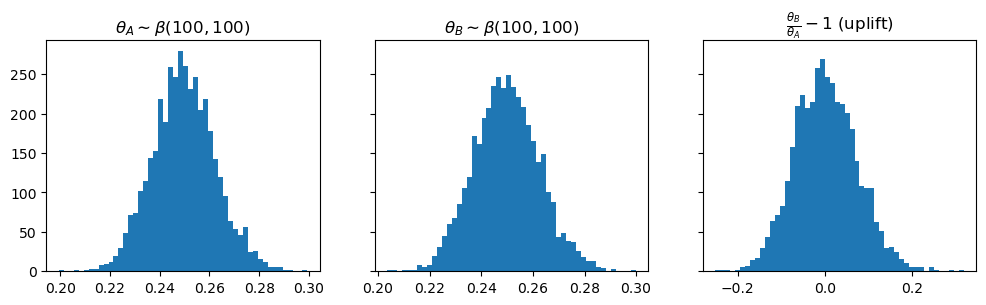

In [25]:
# let's create a  subplot with three plots in a row that shows the theta_A, theta_B and uplift
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# plot the distribution of theta_A
ax[0].hist(weak_outcome['theta_A'],bins=50,)
ax[0].set_title(r'$\theta_A \sim \beta (100,100)$')

# plot the distribution of theta_B
ax[1].hist(weak_outcome['theta_B'],bins=50,)
ax[1].set_title(r'$\theta_B \sim \beta (100,100)$')

# plot the distribution of uplift
ax[2].hist(weak_outcome['uplift'], bins=50,)
ax[2].set_title(r'$\frac{\theta_B}{\theta_A} - 1$ (uplift)')

plt.show()


- Do the beta distributions look familiar? 🤔
- The uplift is centered around zero. Surprise? 🤔

## PyMC Visualisation Options

Let's redo the previous example but this time we set the `return_inferencedata` to True. This will return an `InferenceData` object which we can use to visualise the posterior distributions. The `InferenceData` object contains the posterior samples, the prior and the likelihood and many other details about the model.

In [26]:
with pm.Model() as example_model:

    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = weak_alpha, 
                    beta  = weak_beta, 
                    shape = 2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Binomial("y", 
                      n        = trials, 
                      observed = successes, 
                      p        = theta,
                      shape    = 2) 
    
    # Difference between variants
    relative_uplift = pm.Deterministic("uplift", 
                                        theta[1] / theta[0] - 1)

    # Draw samples from the prior
    trace = pm.sample(draws=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [27]:
# let's check the trace
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In the above result, click on the **posterior** tab:

- What do you see under the **Data variables** section?
- What do you see under the **Dimensions** section?
- What do you see under the **Data variables** section?
- click on the icon at the right-end of the **theta** row. What do you see?


In [ ]:
# check the shape of the trace
trace.posterior.uplift.shape

(4, 5000, 2)

In [43]:
# let's check the summary statistics of the output of the posterior distribution
pm.summary(trace, var_names=["theta", "uplift"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.250,0.013,0.226,0.273,0.000,0.000,4040.0,2774.0,1.0
theta[1],0.250,0.012,0.227,0.273,0.000,0.000,4241.0,3094.0,1.0
uplift,0.003,0.070,-0.122,0.142,0.001,0.001,4214.0,2768.0,1.0


We can also use the ArviZ library for plotting. The main advantage is that it works pretty well with the output data. Also, it gives the HDI for the Relative Uplift distribution.

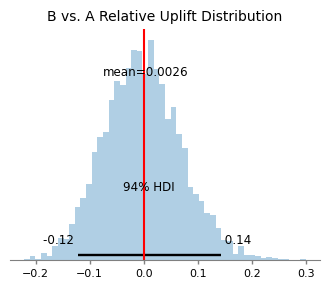

In [42]:
az.plot_posterior(trace.posterior["uplift"], **plotting_defaults, figsize=(4, 3)) # 

plt.title("B vs. A Relative Uplift Distribution", fontsize=10)
plt.axvline(x=0, color="red");

There are many other plots that you can do with ArviZ. You can find more examples [here](https://arviz-devs.github.io/arviz/examples/index.html). 

Let's try a few of them.

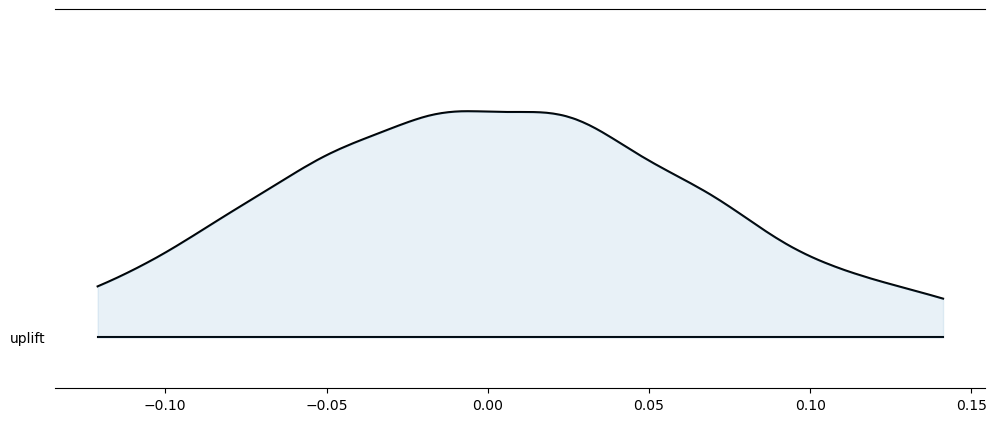

In [49]:
# Let's try a different way to show the posterior distribution of the uplift
az.plot_forest(trace, var_names=["uplift"], 
                        combined=True, 
                        kind= "ridgeplot", 
                        ridgeplot_alpha=0.1);

- Set `combined=False` and run the code. Does the 4 chains ring a 🔔?
- Set `kind= "forestplot"`. What do you see? 🤔

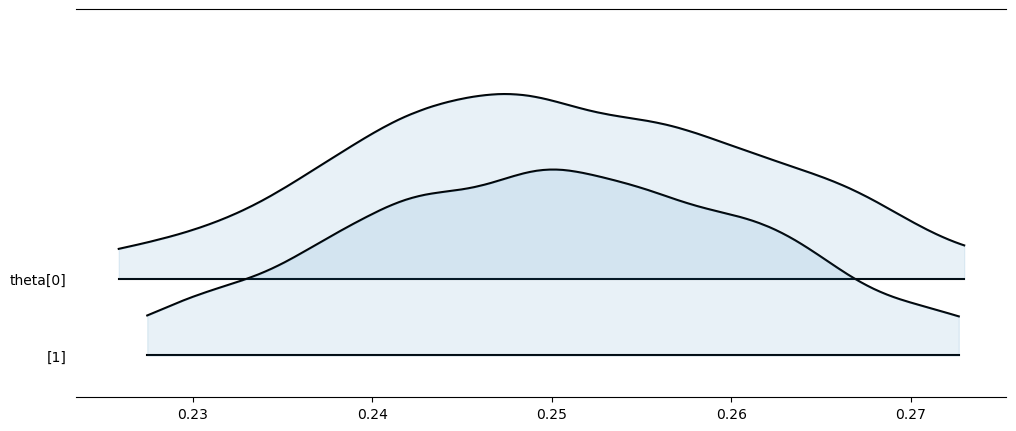

In [50]:
# what about the theta distributions?
az.plot_forest(trace, var_names=["theta"], combined=True, kind="ridgeplot", ridgeplot_alpha=0.1);

With `plot_trace` we get a full picture.

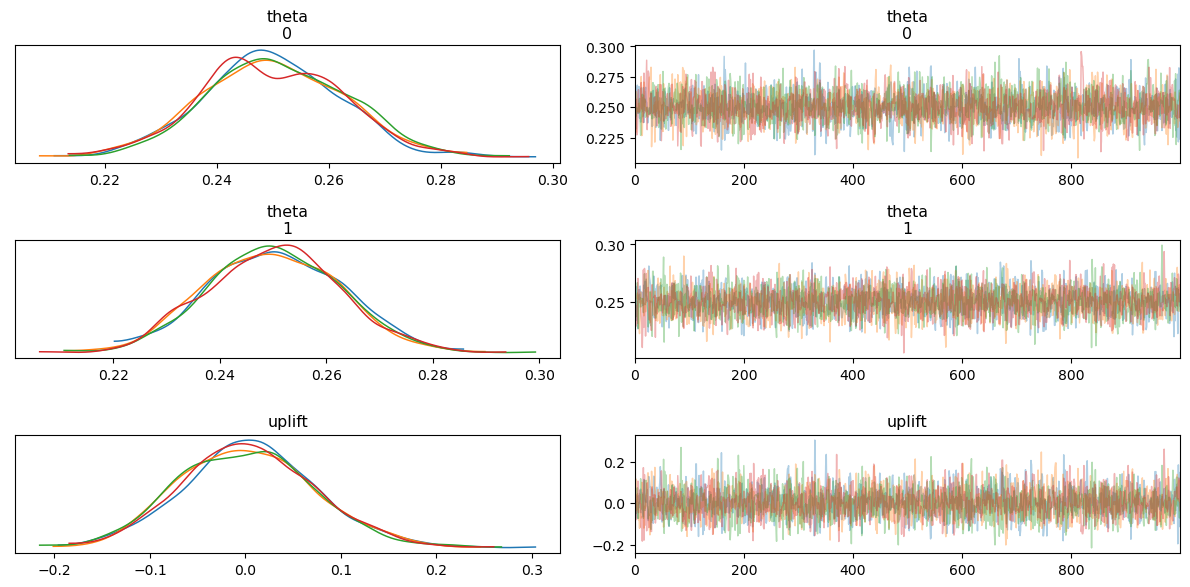

In [51]:
az.plot_trace(trace, compact=False, combined=False)
plt.tight_layout();

- Try changing the `compact` and `combined` parameters. What do you see? 🤔

Yet another view with `plot_pair` and `plot_violin`:

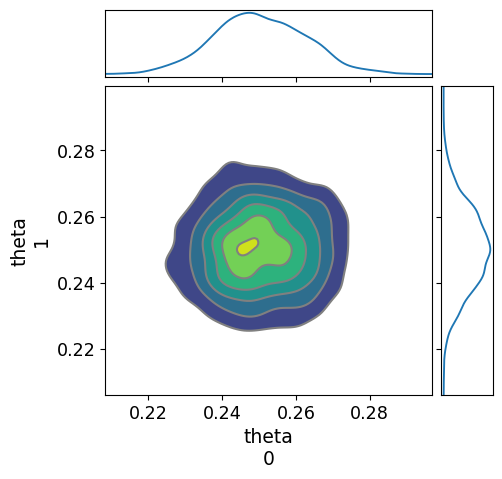

In [59]:
az.plot_pair(trace, var_names=["theta"], kind="kde", marginals=True, figsize=(5, 5));

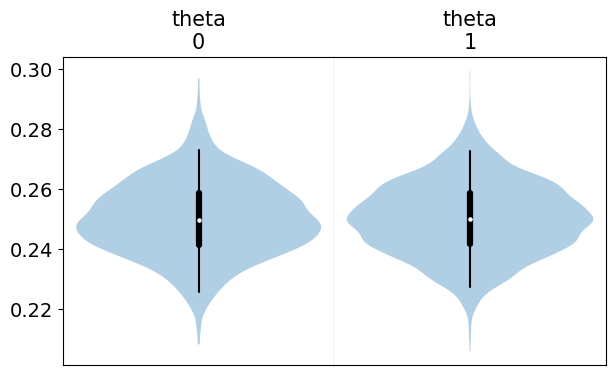

In [62]:
az.plot_violin(trace, var_names=["theta"], figsize=(7, 4));

## Your Second Try
Let's keep the same Beta priors but change the conversion rates to 0.2 and 0.3.

In [ ]:
# let's define the variants A and B
variants  = ['A', 'B']

# each variant has 1000 trail 
trials    = [1000, 1000]

# 200 of which leads to success
successes = [200, 300]

# let's define alpha and beta parameters for a weak prior
weak_priors = [100, 100]

To make the code simpler we can use the `tools.py` python file. This file contains a function called `get_posterior` that will generate the data for us.

In [366]:
%run -i tools.py

In [77]:
trace_weak =  get_posterior(priors    = [100, 100], 
                            trials    = [1000, 1000], 
                            successes = [200, 300]
                              )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


### Task 1
- Try a few of the plots we have seen before. 
- What's your conclution about the difference between A and B? 🤔

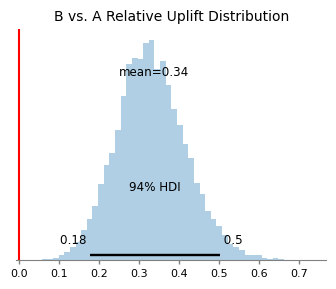

In [81]:
az.plot_posterior(trace_weak.posterior["uplift"], **plotting_defaults, figsize=(4, 3)) # 

plt.title("B vs. A Relative Uplift Distribution", fontsize=10)
plt.axvline(x=0, color="red");

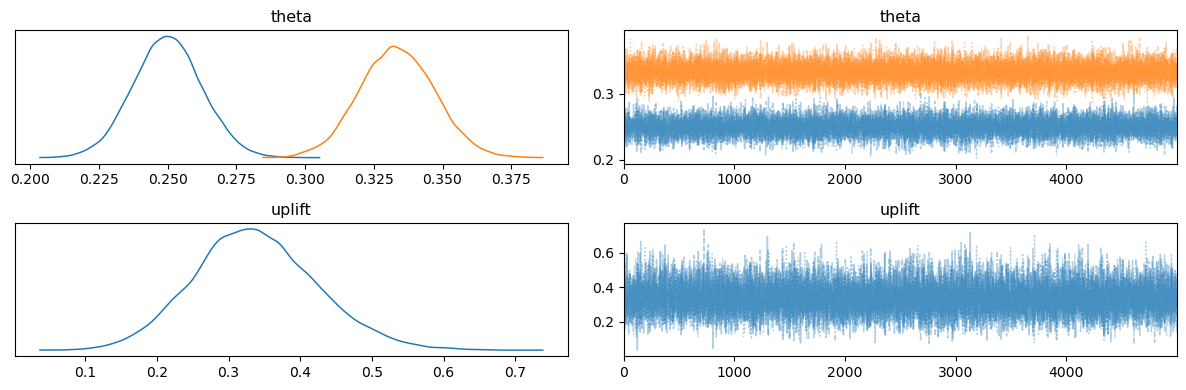

In [82]:
az.plot_trace(trace_weak, compact=True, combined=True)
plt.tight_layout();

### Task 2
- Try a stronger priors, with `alpha=1000` and `beta=1000`, and get the posterior.
- What's your conclution about the difference between A and B? 🤔 

    Answer: stronger prior made the impact of the data smaller, i.e. the difference between A and B is smaller.

In [73]:
trace_strong =  get_posterior(priors    = [1000, 1000], 
                              trials    = [1000, 1000], 
                              successes = [200, 300]
                              )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


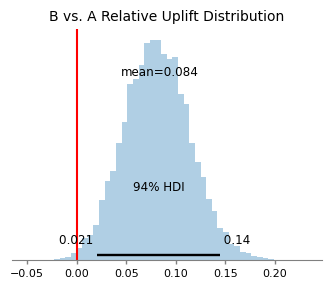

In [79]:
az.plot_posterior(trace_strong.posterior["uplift"], **plotting_defaults, figsize=(4, 3)) # 

plt.title("B vs. A Relative Uplift Distribution", fontsize=10)
plt.axvline(x=0, color="red");

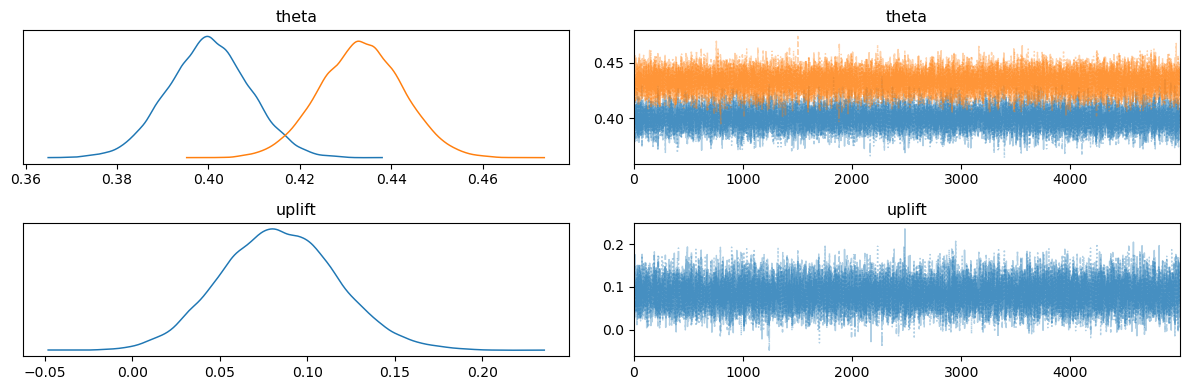

In [80]:
az.plot_trace(trace_strong, compact=True, combined=True)
plt.tight_layout();

### Task 3
- Vary the sample size and investigate how the uplift changes. Consider the weak and strong priors and the following sample sizes: [50, 100, 300, 600, 1000, 1500]
- What's your conclution about the difference between A and B? 🤔

In [367]:
trace_weak_all = sample_size_effect(sample_sizes   = [20, 50, 100, 200, 500, 1000], 
                                    prior          = [100, 100], 
                                    successes_rate = [0.2, 0.25])

trace_strong_all = sample_size_effect(sample_sizes   = [20, 50, 100, 200, 500, 1000], 
                                      prior          = [1000, 1000], 
                                      successes_rate = [0.2, 0.25])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS

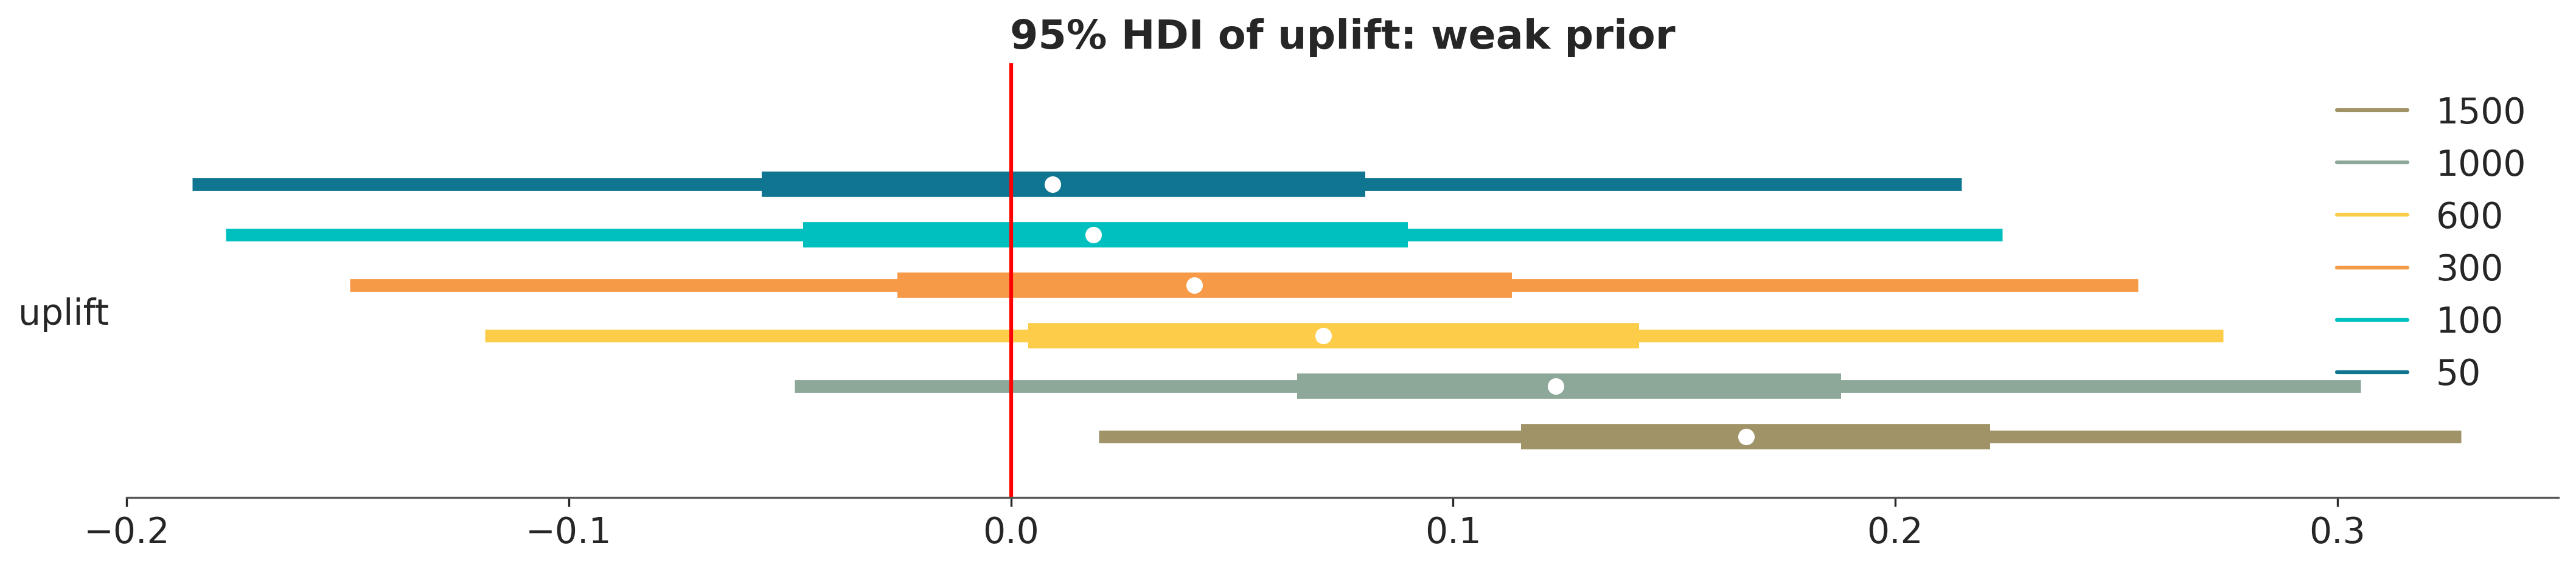

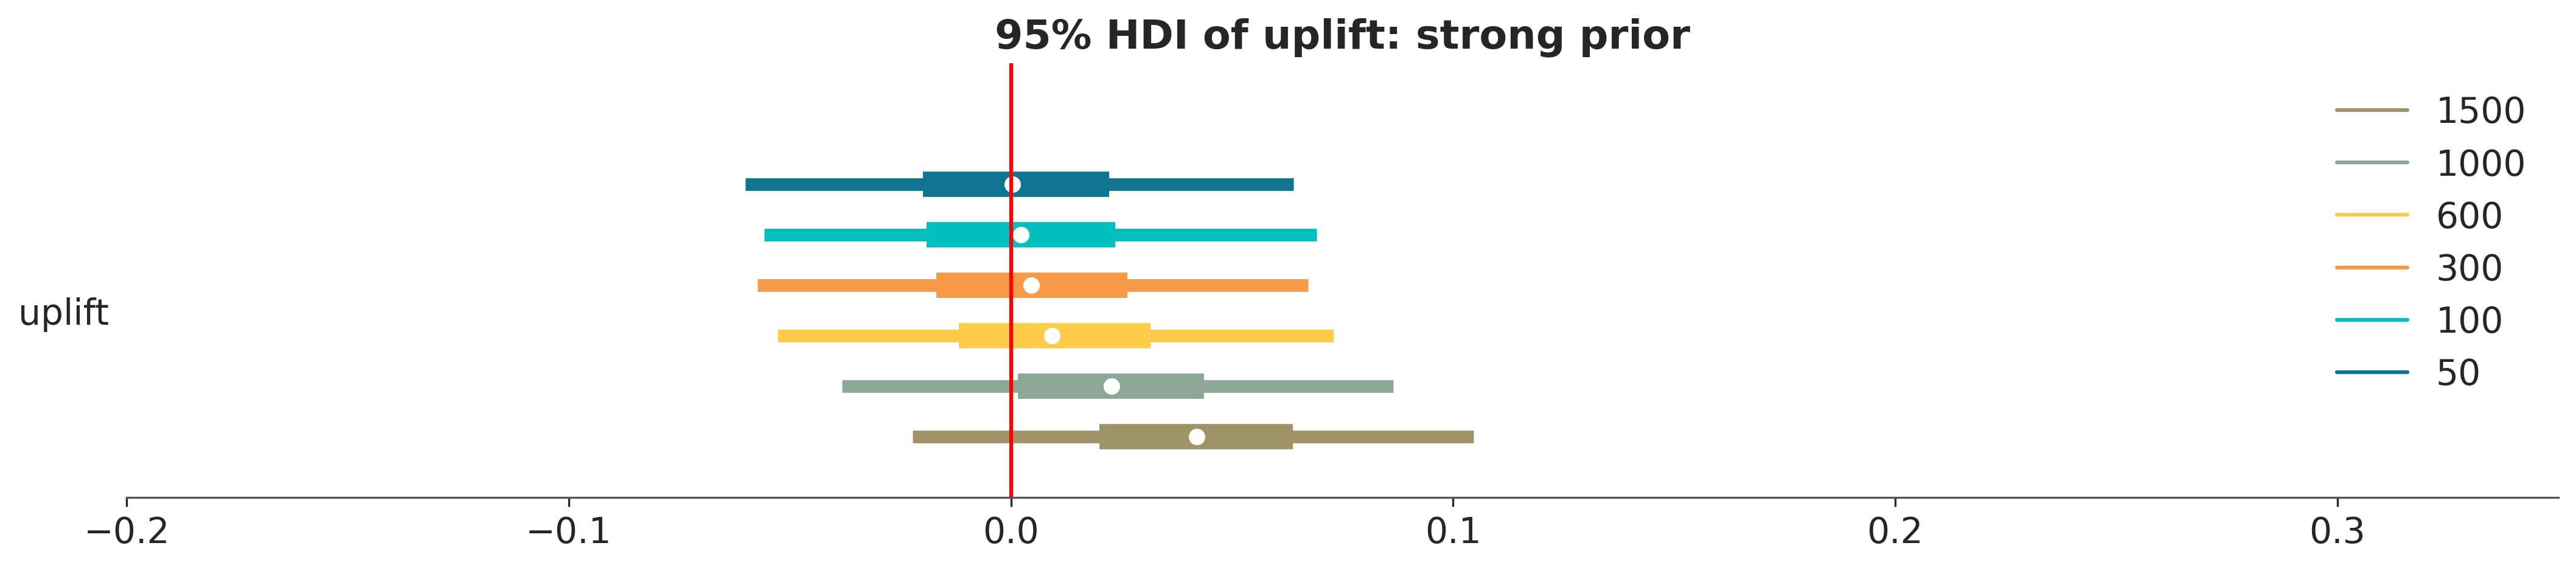

In [379]:
sample_sizes   = [20, 50, 100, 200, 500, 1000]

ax=az.plot_forest(
                [trace_weak_all[i] for i in sample_sizes],
                model_names=['50', '100', '300', '600', '1000', '1500'],
                var_names=["uplift"],
                combined=True,
                hdi_prob=0.95,
                figsize=(14, 3),
                markersize=10,
                linewidth=5,
                   )
plt.axvline(x=0, color="red");
ax[0].set_title("95% HDI of uplift: weak prior")
ax[0].set_xlim(-0.2,0.35)

ax=az.plot_forest(
                [trace_strong_all[i] for i in sample_sizes],
                model_names=['50', '100', '300', '600', '1000', '1500'],
                var_names=["uplift"],
                combined=True,
                hdi_prob=0.95,
                figsize=(14, 3),
                markersize=10,
                linewidth=5,
                   )
plt.axvline(x=0, color="red");
ax[0].set_title("95% HDI of uplift: strong prior")
ax[0].set_xlim(-0.2,0.35)

plt.tight_layout()
plt.show()

Answer:

- The HDI for the uplift of weak prior jumps up very quickly by increasing the number of trials. This is because the posterior is mostly driven by the data than the prior.
However, the HDI for the uplift of strong prior is only gradually increasing the number of trials.

- Data has strong evidence for the uplift being positive (0.3 success rate of B vs 0.2 success rate of A). However, the strong prior makes the effect of data less significant. That's why the HDI for the uplift of strong prior includes zero until the number of trials is large enough.

- On the other hand, the HDI for the uplift of weak prior barely includes zero. This is because the posterior is mostly driven by the data than the prior.

- The uplift distribution of weak prior is more spread out than the strong prior. This is because the weak prior is less informative (high uncertainty) than the strong prior.

observations:

- the uplift distribution of weak prior is more spread out than the strong prior. This is because the weak prior is less informative (high uncertainty) than the strong prior.
- however, when sample size increase, the uplift distribution of weak prior becomes narrower.

- the uplift distribution of the strong prior is more concentrated around zero than the weak prior. This is because the strong prior is more informative (low uncertainty) than the weak prior.

- the HDI for the uplift of weak prior includes zero for sample size up to 300. Since then the HDI indicates that B is better than A.
- however, the HDI for the uplift of strong prior includes zero for sample size up to almost 1000. So the impact of the data is less significant than the weak prior.


- A strong prior can help guard against false discoveries, but may **require more data** to detect winning variants when they exist (and more data = more time required running the test). 
- A weak prior gives **more weight to the observed data**, but could also lead to more false discoveries as a result of early stopping issues.





open questions:
- what if each variant has different beta distribution?
- what if priors aren't beta distribution?
- what if we have more than 2 variants?
- what makes beta distribution a weak or strong prior?
- when deciding about the prior, what is the relation between beta parameters alpha and beta and the number of trials and successes?
